# Matchup satellite data to ship, glider, or animal tracks

## Overview
> History | Updated Mar 2024  

In this exercise you will extract satellite data around a set of points defined by longitude, latitude, and time coordinates, like that produced by an animal telemetry tag, and ship track, or a glider tract.

Please note that there may be more efficient ways, more Pythonic ways, to accomplish the tasks in this tutorial. The tutorial was developed to be easier to follow for less experienced users of Python.

### The exercise demonstrates the following techniques:

* Loading data from a tab- or comma-separated file
* Plotting the latitude/longitude points onto a map 
* Extracting satellite data along a track
* Saving results as a CSV file
* Plotting the satellite data onto a map  

### Datasets used:
- Chlorophyll a concentration from the European Space Agency's Ocean Colour Climate Change Initiative Monthly dataset v6.0
- A glider track that has been subsampled to reduce the data requests needed for this tutorial. The request for the glider track data can be adjusted.

### Python packages used:
- pandas (reading and analyzing data)  
- numpy  (data analysis, manipulation)
- xarray (multi-dimensional data analysis, manipulation)
- matplotlib (mapping)
- cartopy (mapping)
- datetime (date manipulation)

## Import the required Python modules

In [222]:
from IPython.display import clear_output
import pandas as pd
import numpy as np
import os
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import xarray as xr
import requests
import io
import time
from urllib.parse import quote
import datetime
from geopy.distance import geodesic

warnings.filterwarnings('ignore')

# Preview the glider data metadata

Access information about the dataset from the server before attempting to make downloads.

In [223]:
gd_url = 'https://spraydata.ucsd.edu/erddap/tabledap/binnedCUGN90'
gd_ds = xr.open_dataset(gd_url)
gd_ds

<xarray.Dataset>
Dimensions:         (s: 55790)
Dimensions without coordinates: s
Data variables: (12/17)
    s.profile       (s) int32 ...
    s.mission       (s) int32 ...
    s.depth         (s) float64 ...
    s.time          (s) datetime64[ns] ...
    s.latitude      (s) float64 ...
    s.longitude     (s) float64 ...
    ...              ...
    s.v             (s) float64 ...
    s.time_uv       (s) datetime64[ns] ...
    s.lat_uv        (s) float64 ...
    s.lon_uv        (s) float64 ...
    s.u_depth_mean  (s) float64 ...
    s.v_depth_mean  (s) float64 ...
Attributes: (12/64)
    _NCProperties:                   version=2,netcdf=4.8.1,hdf5=1.12.1
    acknowledgement:                 Funded by National Oceanic and Atmospher...
    acknowledgment:                  Funded by National Oceanic and Atmospher...
    cdm_data_type:                   TrajectoryProfile
    cdm_profile_variables:           time_uv,lat_uv,lon_uv,u_depth_mean,v_dep...
    cdm_trajectory_variables:        mission
    ...                              ...
    subsetVariables:                 mission
    summary:                         The overarching goal of the California U...
    time_coverage_end:               2023-07-11T16:35:50Z
    time_coverage_start:             2006-10-19T17:51:00Z
    title:                           California Underwater Glider Network - L...
    Westernmost_Easting:             -122.6719425

## Load the glider data into a Pandas data frame
Below, the track data will load using the Pandas "read_csv" method. 
* Then use the ".head()" method to view the column names and the first few rows of data. 

Get the glider data as a csv file

* Break the url into parts and rejoin it so that it is easier to see.
* Select the dataset and the output format
* Select the output parameters
* Select the constraints, pick a mission (29, spring 2014), depth=10m
* Reducing glider data to one value a day for testing with orderByClosest("time/1day")

In [224]:

gd_csv_url = ''.join(['https://spraydata.ucsd.edu/erddap/tabledap/binnedCUGN90.csv?',
                    'profile%2Cmission%2Cdepth%2Ctime%2Clatitude%2Clongitude%2Ctemperature%2Cchlorophyll',
                    '&mission=29&depth%3E=10&depth%3C=10&orderByClosest("time/1day")'
                    ])

req = requests.get(gd_csv_url).content
df = pd.read_csv(io.StringIO(req.decode('utf-8')), skiprows=[1])#, parse_dates=['time'])
df.head(2)


,profile,mission,depth,time,latitude,longitude,temperature,chlorophyll
0,23117,29,10.0,2014-02-10T23:38:50Z,33.157027,-117.449403,15.644444,0.059133
1,23127,29,10.0,2014-02-12T00:09:30Z,33.104260,-117.525362,15.475900,0.059040


## Plot the track on a map

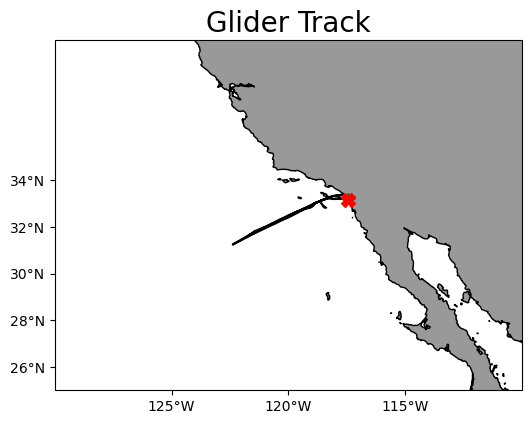

In [225]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 130:
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=130))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([230, 250, 25, 40], ccrs.PlateCarree())

# Set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(235, 250, 5), crs=ccrs.PlateCarree())
ax1.set_yticks(range(26, 36, 2), crs=ccrs.PlateCarree())

# Add feature to the map
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# Format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# Bring the lon and lat data into a numpy array 
x, y = df.longitude.to_numpy(), df.latitude.to_numpy()
ax1 = plt.plot(x, y, transform=ccrs.PlateCarree(), color='k')
# start point in green star
ax1 = plt.plot(x[0], y[0],
               marker='*',
               color='g',
               transform=ccrs.PlateCarree(),
               markersize=10)
# end point in red X
ax1 = plt.plot(x[-1], y[-1],
               marker='X',
               color='r',
               transform=ccrs.PlateCarree(),
               markersize=10)
plt.title('Glider Track', fontsize=20)

plt.show()

## Prepare track data for use to extract satellite data 


## Extract data from a satellite dataset corresponding to glider profile locations

We are going to download data from an ERDDAP server using the following steps: 
* Select a dataset on an ERDDAP server
* Open the dataset using the Xarray module
* Loop though the track data and pull out the date, latitude and longitude coordinates from each row 
* Insert these coordinates into the Xarray open-dataset object to select and download the satellite data that corresponds to the coordinates. 
* Store the satellite data in a temporary Pandas data frame
* Once all the satellite data has been added to the temporary data frame, merge it with the glider data frame.

### Select a dataset

We'll use the European Space Agency's OC-CCI product (https://climate.esa.int/en/projects/ocean-colour/) to obtain chlorophyll data. This is a merged product that blends data from many ocean color sensors to create a long time series (1997-present) with better spatial coverage than any single sensor.


Ideally we would use a daily dataset, selecting the day that corresponds to the track data date. However, chlorophyll measurements can have a lot of missing data, primarily due to cloud cover. To reduce data gaps and improve the likelihood of data for our matchups, we can use a dataset that combines all of the data from each month into the monthly average. 

__The ERDDAP URL to the monthly version of the OC-CCI product is below:__    
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0  
 


###  Open the satellite data in Xarray
* Use the ERDDAP URL with no extension (e.g. without .html or .graph...). This is the OPeNDAP URL, which allows viewing  the dataset metadata and, when you select the data you want, downloading the data.
* Use the Xarray "open_dataset" function then view the metadata

In [226]:
cci_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily'

ds = xr.open_dataset(cci_url)

# Display satellite dataset metadata
ds

<xarray.Dataset>
Dimensions:             (time: 9589, latitude: 4320, longitude: 8640)
Coordinates:
  * time                (time) datetime64[ns] 1997-09-04 ... 2023-12-31
  * latitude            (latitude) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * longitude           (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables: (12/93)
    MERIS_nobs          (time, latitude, longitude) float32 ...
    MODISA_nobs         (time, latitude, longitude) float32 ...
    OLCI_A_nobs         (time, latitude, longitude) float32 ...
    OLCI_B_nobs         (time, latitude, longitude) float32 ...
    Rrs_412             (time, latitude, longitude) float32 ...
    Rrs_412_bias        (time, latitude, longitude) float32 ...
    ...                  ...
    water_class4        (time, latitude, longitude) float32 ...
    water_class5        (time, latitude, longitude) float32 ...
    water_class6        (time, latitude, longitude) float32 ...
    water_class7        (time, latitude, longitude) float32 ...
    water_class8        (time, latitude, longitude) float32 ...
    water_class9        (time, latitude, longitude) float32 ...
Attributes: (12/51)
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    Conventions:                       CF-1.7, COARDS, ACDD-1.3
    creation_date:                     20240117T042504Z
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    time_coverage_end:                 2023-12-31T00:00:00Z
    time_coverage_resolution:          P1D
    time_coverage_start:               1997-09-04T00:00:00Z
    title:                             ESA CCI Ocean Colour Product (CCI ALL-...
    tracking_id:                       ade092d1-55b0-4e6a-bac5-c96b7c4eed03
    Westernmost_Easting:               -179.97916666666666

### Useful Information 
* The spatial and temporal resolution
* nobs variables will show us how many satellite values are included in the matched up cells. We will want to look at these in our analysis and may include in our matchup decision making if useful.

__Opening the dataset in Xarray lets you look at the dataset metadata.__   
* The metadata are listed above.
* No data is downloaded until you request it.  

__From the metadata you can view:__ 
* The coordinates (time, latitude and longitude) that you will use to select the data to download.
* A list of ten data variables. For this exercise, we want the "chlor_a" variable. If you want, you can find out about each variable with clicking the page icon to the right of each variable name. 


__A note on dataset selection__  
We have preselected the OC-CCI monthly dataset because we know it will work with this exercise. If you were selecting datasets on your own, you would want to check out the dataset to determine if its spatial and temporal coverages are suitable for your application. 

You can find that information above by clicking the right arrow next to "Attribute". Then look through the list to find: 
* 'time_coverage_start' and 'time_coverage_end': the time range
* 'geospatial_lat_min' and 'geospatial_lat_max': the latitude range
* 'geospatial_lon_min' and 'geospatial_lon_max': the longitude range

There are a lot of metadata attributes to look through. We can make it easier with a little code to print out the metadata of interest. Then compare these ranges to those found in your track data.


In [227]:
print('Satellite Data:')
print('  Time Range: ', ds.attrs['time_coverage_start'], 
      ds.attrs['time_coverage_end'])
print('  Latitude Range: ', ds.attrs['geospatial_lat_min'], 
      ds.attrs['geospatial_lat_max'])
print('  Longitude Range: ', ds.attrs['geospatial_lon_min'], 
      ds.attrs['geospatial_lon_max'])

print(' ')

print('Glider Data:')
print('  Time Range: ', df.time.min(), df.time.max())
print('  Latitude Range: ', 
      round(df.latitude.min(), 2), round(df.latitude.max(), 2))
print('  Longitude Range: ', 
      round(df.longitude.min(), 2), round(df.longitude.max(), 2))

# Issue with date format. Testing adj the gd date.

Satellite Data:
  Time Range:  1997-09-04T00:00:00Z 2023-12-31T00:00:00Z
  Latitude Range:  -89.97916666666666 89.97916666666667
  Longitude Range:  -179.97916666666666 179.97916666666663
 
Glider Data:
  Time Range:  2014-02-10T23:38:50Z 2014-06-06T17:42:11Z
  Latitude Range:  31.24 33.38
  Longitude Range:  -122.37 -117.45


## CSV Data Access Example

* Make csv data requests for the satellite data and make the matchups. 

* This example builds off the CoastWatch example to specify padding around the glider point in time and space and to filter nan values.

* For now the time request can just be for same day. In the future we will want to do a more detailed analysis of the time matchup to see if matchup results are better for profiles at a certain time of day.

* A good first test will be to pull a grid of satellite data around the glider point and plot it with the location of the glider

In [228]:
# create variables for the unchanging parts of the ERDDAP data-request URL.   
base_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/'
dataset_id = "pmlEsaCCI60OceanColorDaily"
file_type = '.csv'
query_start = '?'
erddap_variable = 'chlor_a'

# create the start of the ERDDAP data-request URL by joining URL components
start_url = ''.join([base_url,
                     dataset_id,
                     file_type,
                     query_start,
                     erddap_variable
                     ])

In [229]:
def is_unique(s):
    a = s.to_numpy() # s.values (pandas<0.24)
    return (a[0] == a).all()



In [ ]:
# Set Matchup Thresholds

# time is first limiting factor 
# cci is daily, will give all timestamps within range
time_thres = datetime.timedelta(days = 0.49) 

# Spatial thresholds
# Start with threshold where we regularly are able to get a chl value
# 10km seemed unnessessary for the test time frame, reduced
# 10km is about ~10th of degree, both lon and lat at our lat
# 72 cells @ .1  |  50 cells at 0.09  |  32 cells at 0.07

lat_thres = 0.09
lon_thres = 0.09 

In [ ]:
# Create dataframe for all the satellite matchup data
sat_start = datetime.datetime.now()

col_names = ["cci_time", "matched_lat", "matched_lon", "matched_chla", "sp_dist"]

sat_df = pd.DataFrame(columns=col_names)
    
# For each row in the glider data frame
# Create the query part of the ERDDAP data-request URL,
# Filter through the satellite data to find the closest/best matchup
# Add satellite matchup info to the glider data frame
    
for i in range(0, len(df)):
    
    print(i+1, 'of', len(df))
    
    # Use glider profile information to form the satellite data request
    
    # Glider point datetime
    g_datetime = datetime.datetime.strptime(df['time'][i], "%Y-%m-%dT%H:%M:%SZ")

    # Datetimes for the request 
    timemin_dt = g_datetime - time_thres
    timemax_dt = g_datetime + time_thres
    
    # String format for request
    timemin = timemin_dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    timemax = timemax_dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    
    # Spatial bounds for the request
    latmin = str(df['latitude'][i] - lat_thres)
    latmax = str(df['latitude'][i] + lat_thres)
    lonmin = str(df['longitude'][i] - lon_thres)
    lonmax = str(df['longitude'][i] + lon_thres)
    
    query_url = ''.join([
                         '[(' + timemin + '):1:(' + timemax + ')]',
                         '[(' + latmin + '):1:(' + latmax + ')]', 
                         '[(' + lonmin + '):1:(' + lonmax + ')]'
                         ])
    
    encoded_query = quote(query_url, safe='')

    print(start_url + query_url)

    url = start_url + encoded_query

    # Download the data as a CSV file directly into Pandas
    # The CCI Dataset is ultimately hosted on an ESA server 
    # that appears to be painfully slow
    new = pd.read_csv(url, skiprows=1)
    new.columns = col_names[0:4]
    
    #print('Number of cells returned in search radius: ' +str(len(new)))
    
    
    if new['matched_chla'].isnull().all():
        print('** No valid matches within search area')
    else:
        print('* Found data, finding best match...')
        
        # NAN FILTER
        # First, filter out matches without chl values, false returns
        # Reasons for no satellite chl include land and clouds
        new = new.loc[new['matched_chla'].notnull()]
        new = new.reset_index(drop=True)
        print(new)
        # TIME FILTER
        # Sometimes more than one time is returned.
        # Chlorophyll is daily, highly variable per day
        # It would be reasonable to test impact of filtering time first or location first.
        # If more than one time is returned, filter to only use the closest
        if not is_unique(new['cci_time']):
            
            # find closest time
            cci_datetimes=[]
            for j in range(0, len(new)):
                cci_datetimes.append(datetime.datetime.strptime(new['cci_time'].iloc[j], "%Y-%m-%dT%H:%M:%SZ"))
                         
            # filter to closest timestamp
            time_diffs = [abs(g_datetime-item) for item in cci_datetimes]
            which_time_diffs = [i for i,v in enumerate(time_diffs) if v == min(time_diffs)]
            print(which_time_diffs)
            print(new)
            new = new.loc[which_time_diffs]
        
        new

        # DISTANCE FILTER
        # Calculate spatial distances
        
        glider_loc = (df['latitude'][i], df['longitude'][i])
        dists = []
        for j in range(0, len(new)):
            satellite_loc = (new['matched_lat'].iloc[j], new['matched_lon'].iloc[j])
            dist = geodesic(glider_loc, satellite_loc).km
            dists.append(dist)
            
        new['sp_dist'] = dists
        
        print(new)
        
        # Filter to closest cell
        new = new.loc[new['sp_dist'] == min(dists)]
        print(new)

        # new df should be a single row now.
        # Note: This may not be the best matchup choice, need to make plots/analyze
        
        # Add the matchup to the df
        sat_df = pd.concat([sat_df, new], ignore_index=True)
    

    # Give server a little break before the next request
    time.sleep(2)
    
sat_df
    

1 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-10T11:53:14Z):1:(2014-02-11T11:24:26Z)][(33.0870275):1:(33.2270275)][(-117.5194025):1:(-117.37940250000001)]
* Found data, finding best match...
               cci_time  matched_lat  matched_lon  matched_chla
0  2014-02-10T00:00:00Z    33.229167  -117.520833      0.883252
1  2014-02-10T00:00:00Z    33.229167  -117.479167      1.532990
2  2014-02-10T00:00:00Z    33.229167  -117.437500      1.532990
3  2014-02-10T00:00:00Z    33.187500  -117.437500      1.197089
               cci_time  matched_lat  matched_lon  matched_chla    sp_dist
0  2014-02-10T00:00:00Z    33.229167  -117.520833      0.883252  10.410568
1  2014-02-10T00:00:00Z    33.229167  -117.479167      1.532990   8.468539
2  2014-02-10T00:00:00Z    33.229167  -117.437500      1.532990   8.077421
3  2014-02-10T00:00:00Z    33.187500  -117.437500      1.197089   3.557296
               cci_time  matched_lat  matched_lon  matc

4 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-13T13:31:22Z):1:(2014-02-14T13:02:34Z)][(33.15296):1:(33.29296)][(-117.756705):1:(-117.61670500000001)]
* Found data, finding best match...
               cci_time  matched_lat  matched_lon  matched_chla
0  2014-02-14T00:00:00Z    33.145833  -117.604167      0.313484
1  2014-02-15T00:00:00Z    33.229167  -117.770833      0.326830
[0]
               cci_time  matched_lat  matched_lon  matched_chla
0  2014-02-14T00:00:00Z    33.145833  -117.604167      0.313484
1  2014-02-15T00:00:00Z    33.229167  -117.770833      0.326830
               cci_time  matched_lat  matched_lon  matched_chla    sp_dist
0  2014-02-14T00:00:00Z    33.145833  -117.604167      0.313484  11.507377
               cci_time  matched_lat  matched_lon  matched_chla    sp_dist
0  2014-02-14T00:00:00Z    33.145833  -117.604167      0.313484  11.507377
5 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI6

9 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-18T11:07:48Z):1:(2014-02-19T10:39:00Z)][(33.006992499999996):1:(33.146992499999996)][(-118.78693):1:(-118.64693000000001)]
** No valid matches within search area
10 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-19T12:34:53Z):1:(2014-02-20T12:06:05Z)][(32.911272499999995):1:(33.051272499999996)][(-118.99761249999999):1:(-118.8576125)]
* Found data, finding best match...
                cci_time  matched_lat  matched_lon  matched_chla
0   2014-02-21T00:00:00Z    33.062500  -118.979167      0.586377
1   2014-02-21T00:00:00Z    33.062500  -118.937500      0.425085
2   2014-02-21T00:00:00Z    33.062500  -118.895833      0.296467
3   2014-02-21T00:00:00Z    33.062500  -118.854167      0.296467
4   2014-02-21T00:00:00Z    33.020833  -118.979167      0.508990
5   2014-02-21T00:00:00Z    33.020833  -118.937500      0.590014
6   2014-02

12 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-21T12:18:02Z):1:(2014-02-22T11:49:14Z)][(32.717805):1:(32.857805)][(-119.3951475):1:(-119.2551475)]
** No valid matches within search area
13 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-22T12:33:01Z):1:(2014-02-23T12:04:13Z)][(32.606455000000004):1:(32.746455000000005)][(-119.63687499999999):1:(-119.496875)]
** No valid matches within search area
14 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-23T11:41:40Z):1:(2014-02-24T11:12:52Z)][(32.51475):1:(32.65475)][(-119.85882):1:(-119.71882000000001)]
** No valid matches within search area
15 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-02-24T13:32:14Z):1:(2014-02-25T13:03:26Z)][(32.4211575):1:(32.5611575)][(-120.0667625):1:(-119.92676250000001)]
** No valid matches wit

21 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-02T12:12:58Z):1:(2014-03-03T11:44:10Z)][(31.904685):1:(32.044685)][(-121.09964):1:(-120.95964000000001)]
** No valid matches within search area
22 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-03T13:41:14Z):1:(2014-03-04T13:12:26Z)][(31.79458):1:(31.93458)][(-121.3268025):1:(-121.18680250000001)]
* Found data, finding best match...
                cci_time  matched_lat  matched_lon  matched_chla
0   2014-03-05T00:00:00Z    31.937500  -121.312500      0.168657
1   2014-03-05T00:00:00Z    31.937500  -121.270833      0.199211
2   2014-03-05T00:00:00Z    31.937500  -121.229167      0.199211
3   2014-03-05T00:00:00Z    31.937500  -121.187500      0.220370
4   2014-03-05T00:00:00Z    31.895833  -121.312500      0.191835
5   2014-03-05T00:00:00Z    31.895833  -121.270833      0.177012
6   2014-03-05T00:00:00Z    31.895833  -121.2291

26 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-07T11:24:08Z):1:(2014-03-08T10:55:20Z)][(31.4266):1:(31.5666)][(-122.0180175):1:(-121.87801750000001)]
* Found data, finding best match...
                cci_time  matched_lat  matched_lon  matched_chla
0   2014-03-07T00:00:00Z    31.562500  -122.020833      0.199817
1   2014-03-07T00:00:00Z    31.562500  -121.979167      0.211948
2   2014-03-07T00:00:00Z    31.562500  -121.937500      0.200387
3   2014-03-07T00:00:00Z    31.562500  -121.895833      0.201526
4   2014-03-07T00:00:00Z    31.520833  -122.020833      0.197273
5   2014-03-07T00:00:00Z    31.520833  -121.979167      0.220620
6   2014-03-07T00:00:00Z    31.520833  -121.937500      0.220620
7   2014-03-07T00:00:00Z    31.520833  -121.895833      0.208030
8   2014-03-07T00:00:00Z    31.479167  -121.979167      0.206031
9   2014-03-07T00:00:00Z    31.479167  -121.937500      0.221649
10  2014-03-07T00:00:00Z    31.479167  -

28 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-09T12:08:45Z):1:(2014-03-10T11:39:57Z)][(31.275575):1:(31.415575)][(-122.27219):1:(-122.13219000000001)]
* Found data, finding best match...
                cci_time  matched_lat  matched_lon  matched_chla
0   2014-03-10T00:00:00Z    31.395833  -122.270833      0.107589
1   2014-03-10T00:00:00Z    31.395833  -122.229167      0.113697
2   2014-03-10T00:00:00Z    31.395833  -122.187500      0.120616
3   2014-03-10T00:00:00Z    31.395833  -122.145833      0.135105
4   2014-03-10T00:00:00Z    31.354167  -122.270833      0.109303
5   2014-03-10T00:00:00Z    31.354167  -122.229167      0.109303
6   2014-03-10T00:00:00Z    31.354167  -122.187500      0.118867
7   2014-03-10T00:00:00Z    31.354167  -122.145833      0.122657
8   2014-03-10T00:00:00Z    31.312500  -122.270833      0.099288
9   2014-03-10T00:00:00Z    31.312500  -122.229167      0.109001
10  2014-03-10T00:00:00Z    31.312500 

31 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-12T13:26:11Z):1:(2014-03-13T12:57:23Z)][(31.1724375):1:(31.3124375)][(-122.44496):1:(-122.30496000000001)]
* Found data, finding best match...
                cci_time  matched_lat  matched_lon  matched_chla
0   2014-03-13T00:00:00Z    31.312500  -122.437500      0.199989
1   2014-03-13T00:00:00Z    31.312500  -122.395833      0.191173
2   2014-03-13T00:00:00Z    31.312500  -122.354167      0.185890
3   2014-03-13T00:00:00Z    31.312500  -122.312500      0.185890
4   2014-03-13T00:00:00Z    31.270833  -122.437500      0.189492
5   2014-03-13T00:00:00Z    31.270833  -122.395833      0.184624
6   2014-03-13T00:00:00Z    31.270833  -122.354167      0.168084
7   2014-03-13T00:00:00Z    31.270833  -122.312500      0.162333
8   2014-03-13T00:00:00Z    31.229167  -122.437500      0.178380
9   2014-03-13T00:00:00Z    31.229167  -122.395833      0.172117
10  2014-03-13T00:00:00Z    31.22916

33 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-14T11:12:27Z):1:(2014-03-15T10:43:39Z)][(31.35978):1:(31.49978)][(-122.08624999999999):1:(-121.94625)]
* Found data, finding best match...
                cci_time  matched_lat  matched_lon  matched_chla
0   2014-03-14T00:00:00Z    31.479167  -122.104167      0.163429
1   2014-03-14T00:00:00Z    31.479167  -122.062500      0.166251
2   2014-03-14T00:00:00Z    31.479167  -122.020833      0.167879
3   2014-03-14T00:00:00Z    31.479167  -121.979167      0.164329
4   2014-03-14T00:00:00Z    31.479167  -121.937500      0.164182
5   2014-03-14T00:00:00Z    31.437500  -122.104167      0.170767
6   2014-03-14T00:00:00Z    31.437500  -122.062500      0.168335
7   2014-03-14T00:00:00Z    31.437500  -122.020833      0.168446
8   2014-03-14T00:00:00Z    31.437500  -121.979167      0.160271
9   2014-03-14T00:00:00Z    31.437500  -121.937500      0.160271
10  2014-03-14T00:00:00Z    31.395833  -

35 of 117
https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI60OceanColorDaily.csv?chlor_a[(2014-03-16T12:12:06Z):1:(2014-03-17T11:43:18Z)][(31.612077499999998):1:(31.7520775)][(-121.5898275):1:(-121.44982750000001)]
* Found data, finding best match...
                cci_time  matched_lat  matched_lon  matched_chla
0   2014-03-17T00:00:00Z    31.770833  -121.604167      0.126854
1   2014-03-17T00:00:00Z    31.770833  -121.562500      0.122431
2   2014-03-17T00:00:00Z    31.770833  -121.520833      0.110137
3   2014-03-17T00:00:00Z    31.770833  -121.479167      0.110137
4   2014-03-17T00:00:00Z    31.770833  -121.437500      0.121481
5   2014-03-17T00:00:00Z    31.729167  -121.604167      0.149205
6   2014-03-17T00:00:00Z    31.729167  -121.562500      0.149205
7   2014-03-17T00:00:00Z    31.729167  -121.520833      0.139538
8   2014-03-17T00:00:00Z    31.729167  -121.479167      0.126464
9   2014-03-17T00:00:00Z    31.729167  -121.437500      0.120635
10  2014-03-17T00:00:00Z  

In [ ]:
print(type(which_time_diffs))
new2 = new.loc[which_time_diffs]

### Add the downloaded satellite data to the glider data frame

In [ ]:
df[['matched_lat', 
    'matched_lon', 
    'matched_chla', 
    'cci_time',
    'sp_dist']] = tot[['matched_lat',
                        'matched_lon',
                        'matched_chla',
                        'cci_time',
                        'sp_dist']]


df


### Save your work

In [ ]:
df.to_csv('chl_matchup.csv', index=False, encoding='utf-8')

## Plot chlorophyll matchup data onto a map

### First plot a histogram of the chlorophyll data

In [ ]:
print('Range:', df.matched_chla.min(), df.matched_chla.max())
_ = df.matched_chla.hist(bins=40)

The range of chlorophyll values can be large, with lots of very low values and a few very high values. Using a  linear color bar,  most of the lower values would have the same color.
* To better visualize the data, we often plot the log or log10 of chlorophyll. 

### Plot a histogram of the log of the chlorophyll data

In [ ]:
print('Range:', np.log(df.matched_chla.min()), np.log(df.matched_chla.max()))
_ = np.log(df.matched_chla).hist(bins=40)

* The logarithmic transformation displays the range of values across the color bar range (above). 

### Map the chlorophyll data
This plot is not very insightful for our use case. Timeseries and scatter plots found in other tutorials would be better.

In [ ]:
plt.figure(figsize=(14, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:

# set the projection
ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=180))

# Use the lon and lat ranges to set the extent of the map
# the 120, 260 lon range will show the whole Pacific
# the 15, 55 lat range with capture the range of the data
ax1.set_extent([230,255, 25, 40], ccrs.PlateCarree())

# set the tick marks to be slightly inside the map extents
ax1.set_xticks(range(230,255,10), crs=ccrs.PlateCarree())
ax1.set_yticks(range(25,35,5), crs=ccrs.PlateCarree())

# Add geographical features
ax1.add_feature(cfeature.LAND, facecolor='0.6')
ax1.coastlines()

# format the lat and lon axis labels
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)

# build and plot coordinates onto map
x,y = list(df.longitude),list(df.latitude)
ax1 = plt.scatter(x, y, transform=ccrs.PlateCarree(),
                  marker='o',
                  c=np.log(df.matched_chla),
                  cmap=plt.get_cmap('jet')
                  )
ax1=plt.plot(x[0],y[0],marker='*', transform=ccrs.PlateCarree(), markersize=10)
ax1=plt.plot(x[-1],y[-1],marker='X', transform=ccrs.PlateCarree(), markersize=10)

# control color bar values spacing
levs2 = np.arange(-2.5, 0, 0.5)
cbar=plt.colorbar(ticks=levs2, shrink=0.75, aspect=10)
cbar.set_label("Chl a (mg/m^3)", size=15, labelpad=20)

# set the labels to be exp(levs2) so the label reflect values of chl-a, not log(chl-a)
cbar.ax.set_yticklabels(np.around(np.exp(levs2), 2), size=10)

plt.title("Chlorophyll Matchup to Glider Track", size=14)
plt.show()

## On your own!

##### Exercise 1:
Repeat the steps above with a different dataset.
For example, extract sea surface temperature data using the NOAA Geo-polar Blended Analysis SST, GHRSST dataset:
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5NRT_Lon0360.html  
* This dataset is a different ERDDAP; It has a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset.   


##### Exercise 2:
Go to an ERDDAP of your choice, find a dataset of interest, generate the URL, copy it and edit the script above to run a match up on that dataset.
To find other ERDDAP servers, you can use this search engine:
http://erddap.com/  
* This dataset will likely be on a different base URL and dataset ID and variable name.
* Check the metadata to make sure the dataset covers the spatial and temporal range of the track dataset. 

##### Optional
Repeat the steps above with a daily version of the OC-CCI dataset to see how cloud cover can reduce the data you retrieve. 
https://oceanwatch.pifsc.noaa.gov/erddap/griddap/CRW_sst_v1_0.html


### Xarray Download Example

*For reference only. Not used.* 

You can download the data using the opendap connection instead of accessing via csv file. There are many advantages to this method especially when working with bigger datasets. However the matchup function demo here is not sophisticated enough for our needs. We need more control over the selection of the matchup. I find it is more transparent to test with the csv output and for my tests I chose to use the csv approach further below instead.


In [ ]:
# Xarray access demo
# Create a temporary Pandas data frame to hold the downloaded satellite data
# 1253 glider profiles in example, further reduced to one a day results in 
# 117 glider points to look for satellite data 
# This method looks only for the nearest point
# Need ability to specify bounding box and to ignore nans so not super useful as-is

xcol_names = ["erddap_date", "matched_lat", "matched_lon", "matched_chla"]

xtot = pd.DataFrame(columns=xcol_names)

# For each point on the in-situ data track
# Find the nearest satellite data point
# Request the satellite data
# Add satellite data to a new pandas data frame
# Finish each URL and download
for i in range(0, 4):# len(df)):
    clear_output(wait=True)
    print(i+1, 'of', len(df))
    
    # Use opendap to extract the data at the point of interest
    # Find the parts of the satellite dataset to include 
    # Selection corresponds to glider locations
    cropped_ds = ds['chlor_a'].sel(time=df.time[i][0:10],
                                   latitude=df.latitude[i],
                                   longitude=df.longitude[i],
                                   method='nearest',
                                   threshold=0.07
                                   )
     
    # Download the data and add it to a new line in the tot data frame
    xtot.loc[len(tot.index)] = [cropped_ds.time.values,
                               np.round(cropped_ds.latitude.values, 5),  # round 5 dec
                               np.round(cropped_ds.longitude.values, 5), # round 5 dec
                               np.round(cropped_ds.values, 2)  # round 2 decimals
                               ]
    
    
    time.sleep(2) # Be nice to the server and space out the requests

xtot